## From a GrowClust output catalog, loop through the defined clusters and find the event within the cluster with the highest SNR.
## Save that event as an eqcorrscan template for matched-filter detection.
## Do this for each cluster!

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from obspy.core.event import read_events
import obspy
import eqcorrscan
import eqcorrscan.core.match_filter.template as template
from obspy.clients.fdsn.client import Client
from eqcorrscan.core.template_gen import template_gen
from eqcorrscan import Tribe
from datetime import datetime

#### Read in GrowClust output catalog:

In [17]:
outfile = 'end_out_0835_2.grid3D.cat'

#### Get a list of distinct clusters:

In [18]:
cat = pd.read_csv(outfile,header=None,delim_whitespace=True)
cat.rename(columns={0:'yr',1:'mon',2:'day',3:'hr',4:'min',5:'sec',6:'evid',7:'latR',8:'lonR',9:'depR',\
                   10:'mag',11:'ev_serialID',12:'clusterID',13:'clustersize',14:'npair',15:'ndiffP',\
                   16:'ndiffS',17:'rmsP',18:'rmsS',19:'erh',20:'erz',21:'ert',22:'latC',23:'lonC',24:'depC'},inplace=True)

# Make a datetime column
cat = cat.astype({'yr':'int','mon':'int','day':'int','hr':'int','min':'int'})
cat['eventTime'] = cat[["yr","mon","day","hr","min"]].apply(lambda x: '-'.join(x.values.astype(int).astype(str)), axis="columns")
cat['eventTime'] = cat[['eventTime','sec']].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
cat['eventTime']=pd.to_datetime(cat['eventTime'],format='%Y-%m-%d-%H-%M-%S.%f')


# Isolate events that actually got relocated
reloc = cat[~cat['rmsP'].isnull()]
clusters = reloc['clusterID'].unique()

#### Read in the catalog that was input to GrowClust:

In [19]:
cat = read_events('endquakes_2017.xml')
# Add in a phase hint to the picks
for event in cat.events:
    for pick in event.picks:
        pick_id = pick.resource_id
        arr = [a for a in event.origins[0].arrivals if a.pick_id==pick_id]
        pick.phase_hint=arr[0].phase
origin_ids = [str(p.resource_id)[-6:] for p in cat]

In [36]:
for event in cat.events:
    event.origins[0].resource_id = event.resource_id

In [37]:
clust = reloc[reloc['clusterID']==c]

#### Loop through clusters and identify the highest SNR event within each cluster.

In [38]:
template_window = [-0.1,2] # time before and after P-wave to trim the template

temp_ev_ids = []
temps = []
for c in clusters:
    
    # Pull in waveforms for one of the clusters
    clust = reloc[reloc['clusterID']==c]
    stream_list = []
    id_list = []
    for id in clust['evid']:
        fid1 = 'sep2017_mseed/'+str(id)+'.mseed'
        strm = obspy.read(fid1).detrend()
         # Filter
        strm.filter('bandpass',freqmin=8,freqmax=35)
        stream_list.append(strm)
        id_list.append(id)
        
    # Cut them to all be the same length
    s_len = np.min([st[0].stats.npts for st in stream_list])
    cut_stream_list = []
    for st in stream_list:
        t1 = st[0].stats.starttime
        t2 = t1 + (s_len/200)
        st.trim(starttime=t1,endtime=t2,nearest_sample=False)
        if st[0].stats.npts > s_len:
            cut_stream_list.append(st[:s_len])
            
    # Find event with highest mean SNR (remember that the miniseeds are saved to have 5 seconds before the P-wave arrival)
    snr = []
    for st in cut_stream_list:
        snr_st = []
        for i,tr in enumerate(st):
            noise_amp = np.sqrt(np.mean(np.square(tr.data[0:900])))
            snr_st.append(max(tr.data) / noise_amp)
        snr.append(np.mean(snr_st))
    t_ind = np.argmax(snr)
    temp_ev_ids.append(id_list[t_ind])
    

In [97]:
len(temp_ev_ids)

12

In [96]:
len(clusters)

12

#### Make a new catalog that consists of the event metadata only for those events with best SNR.

In [151]:
clust_cat = obspy.core.event.Catalog()
for id in temp_ev_ids:
    cat_ind = origin_ids.index(str(id))
    clust_cat.append(cat[cat_ind])

#### Create an eqcorrscan tribe for those events.

In [262]:
# Write templates to a tribe
client = Client('IRIS')
tribe = Tribe().construct(
    method="from_client", lowcut=8.0, highcut=35.0, samp_rate=200.0, length=0.5,
    filt_order=4, prepick=0.05, client_id=client, catalog=clust_cat, data_pad=20.,
    process_len=3600, min_snr=2.0, parallel=True,swin='all',delayed=True)
# Rename each template to have the growclust cluster number and the specific event ID
for i,t in enumerate(tribe):
    t.name = 'growclust'+str(clusters[i])+'_ev'+str(temp_ev_ids[i])

Signal-to-noise ratio 1.9950806047984326 below threshold for ENWF.HHE, not using
No pick for NV.ENWF..HHE


#### Save tribe to file.

In [ ]:
tribe.write('growclust_templates_sep2017')

In [94]:
## Practice detecting with these cluster templates.

In [257]:
# Read in templates
tribe = eqcorrscan.core.match_filter.tribe.read_tribe('growclust_templates_sep2017.tgz')

In [258]:
%%time

# Now detect!
client = Client('IRIS')
t1 = obspy.UTCDateTime("2017-09-29-09")
t2 = obspy.UTCDateTime("2017-09-29-10")

party = tribe.client_detect(client,t1,t2,threshold=6, threshold_type='MAD',trig_int=1,process_cores=4)

Last bit of data between 2017-09-29T09:59:58.440000Z and 2017-09-29T10:00:01.560000Z will go unused because it is shorter than a chunk of 3600.0 s


CPU times: user 4.77 s, sys: 604 ms, total: 5.37 s
Wall time: 6.78 s


## Compare the detections made by a given template to the earthquakes the template represents

### Note: it finds all the original earthquakes if I lower the MAD threshold to 6.

Text(0.5, 1.0, 'Cluster 3')

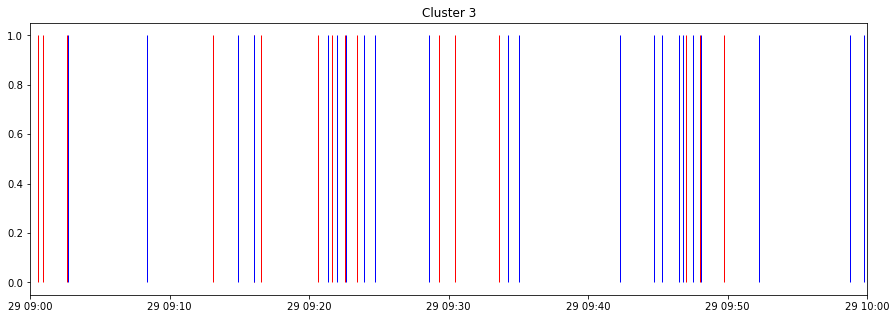

In [256]:
party_ind = 3

temp_name = party[party_ind].template.name
c_id = int(temp_name.split('growclust')[1].split('_')[0])
clust = reloc[reloc['clusterID']==c_id]
cat_compare = obspy.core.event.Catalog()
for id in clust['evid']:
    cat_ind = origin_ids.index(str(id))
    cat_compare.append(cat[cat_ind])

#cat_compare =cat.filter("time > 2017-09-29T09",
#                  "time < 2017-09-29T10")
auto_times = [datetime.strptime(str(c.origins[0].time),'%Y-%m-%dT%H:%M:%S.%fZ') for c in cat_compare]
xcorr_times = [p.detect_time for p in party[party_ind]]


fig, ax = plt.subplots(1, 1,figsize=[15,5])
ax.vlines(x=auto_times,ymin=0,ymax=1,colors ='r',linewidth=1)
ax.vlines(x=xcorr_times,ymin=0,ymax=1,colors ='b',linewidth=1)
ax.set_xlim([datetime(2017,9,29,9),datetime(2017,9,29,10)])
ax.set_title('Cluster ' + str(c_id))

### But not if I keep the MAD treshold higher, at 8

Text(0.5, 1.0, 'Cluster 3')

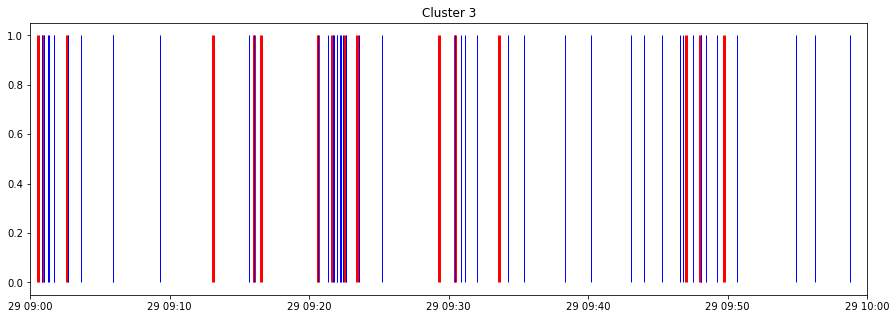

In [261]:
party_ind = 3

temp_name = party[party_ind].template.name
c_id = int(temp_name.split('growclust')[1].split('_')[0])
clust = reloc[reloc['clusterID']==c_id]
cat_compare = obspy.core.event.Catalog()
for id in clust['evid']:
    cat_ind = origin_ids.index(str(id))
    cat_compare.append(cat[cat_ind])

#cat_compare =cat.filter("time > 2017-09-29T09",
#                  "time < 2017-09-29T10")
auto_times = [datetime.strptime(str(c.origins[0].time),'%Y-%m-%dT%H:%M:%S.%fZ') for c in cat_compare]
xcorr_times = [p.detect_time for p in party[party_ind]]


fig, ax = plt.subplots(1, 1,figsize=[15,5])
ax.vlines(x=auto_times,ymin=0,ymax=1,colors ='r',linewidth=3)
ax.vlines(x=xcorr_times,ymin=0,ymax=1,colors ='b',linewidth=1)
ax.set_xlim([datetime(2017,9,29,9),datetime(2017,9,29,10)])
ax.set_title('Cluster ' + str(c_id))

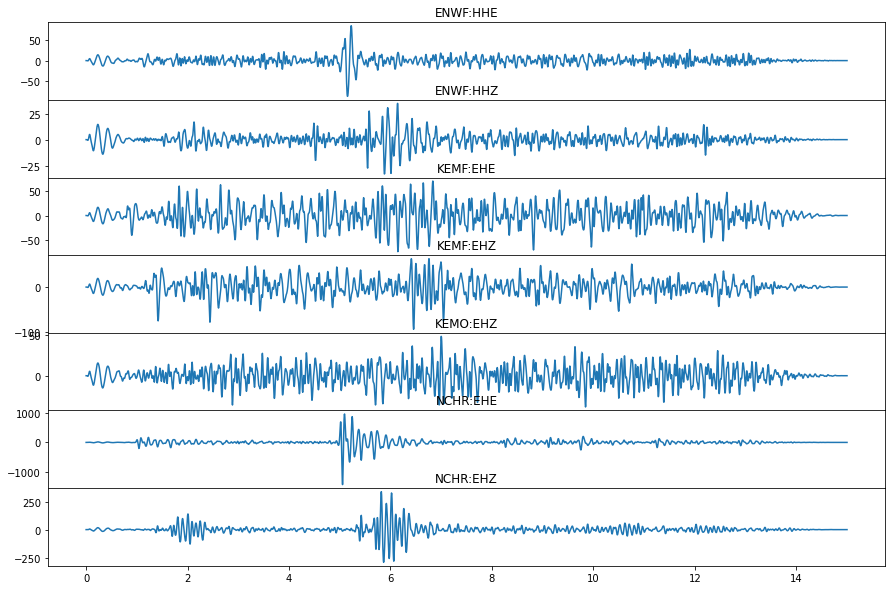

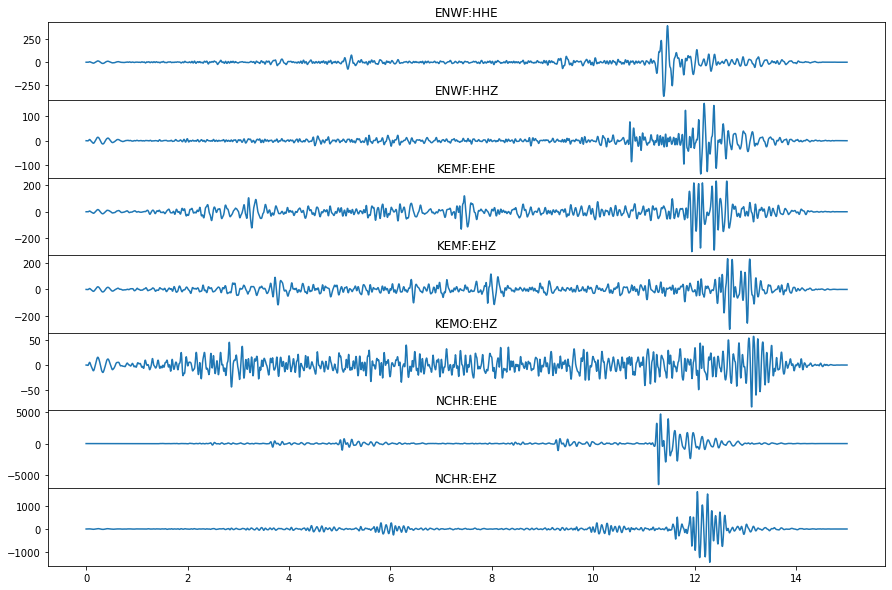

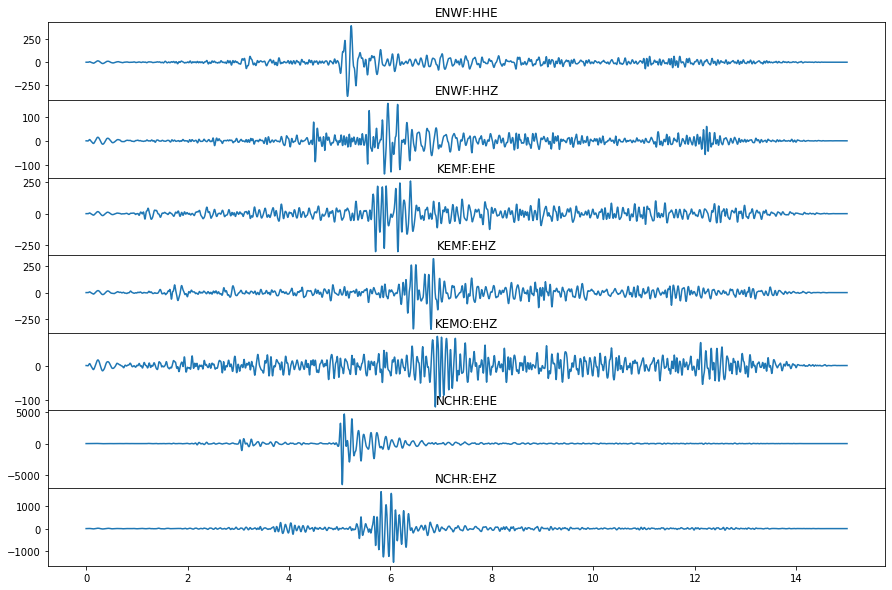

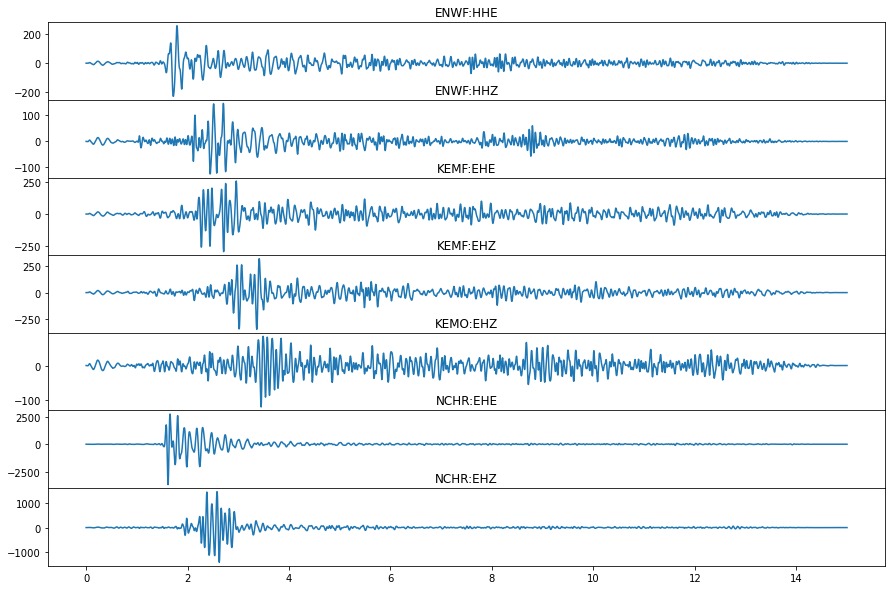

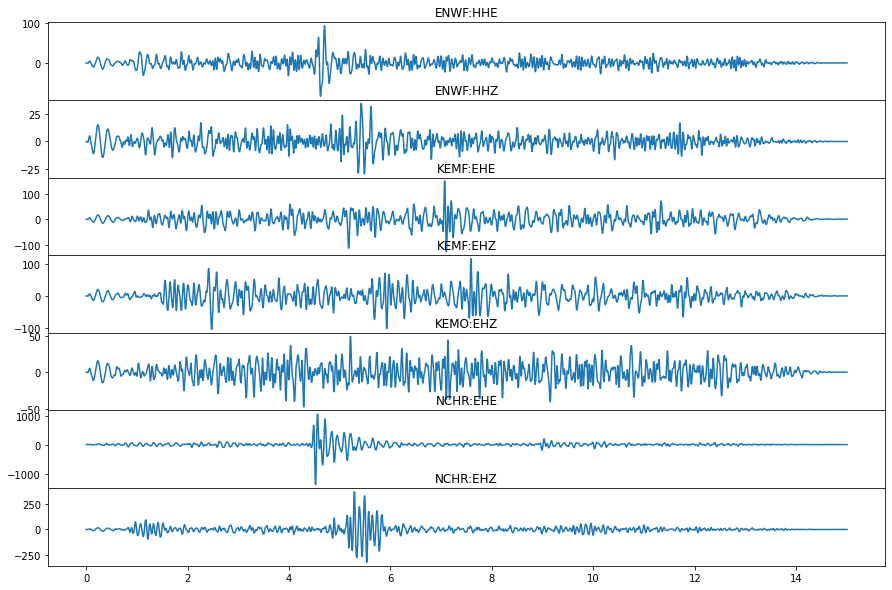

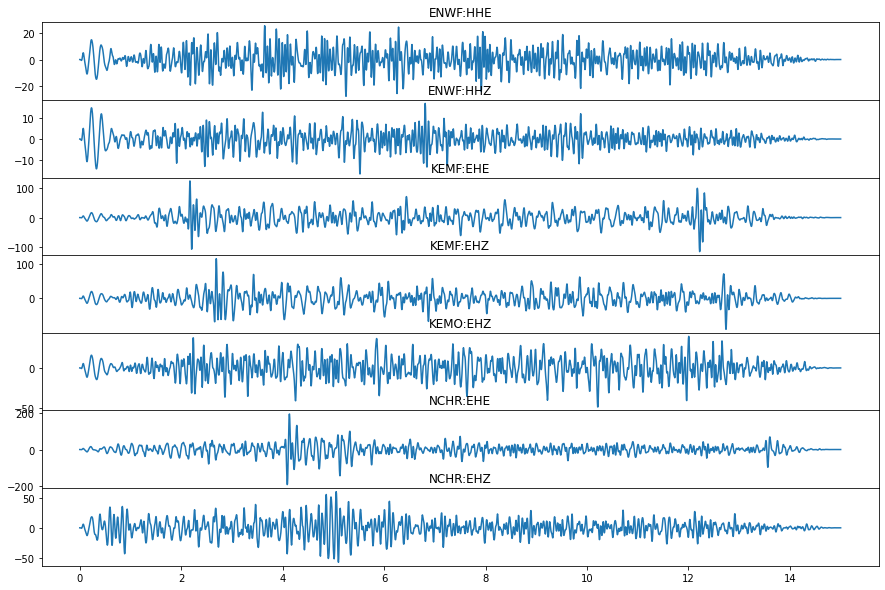

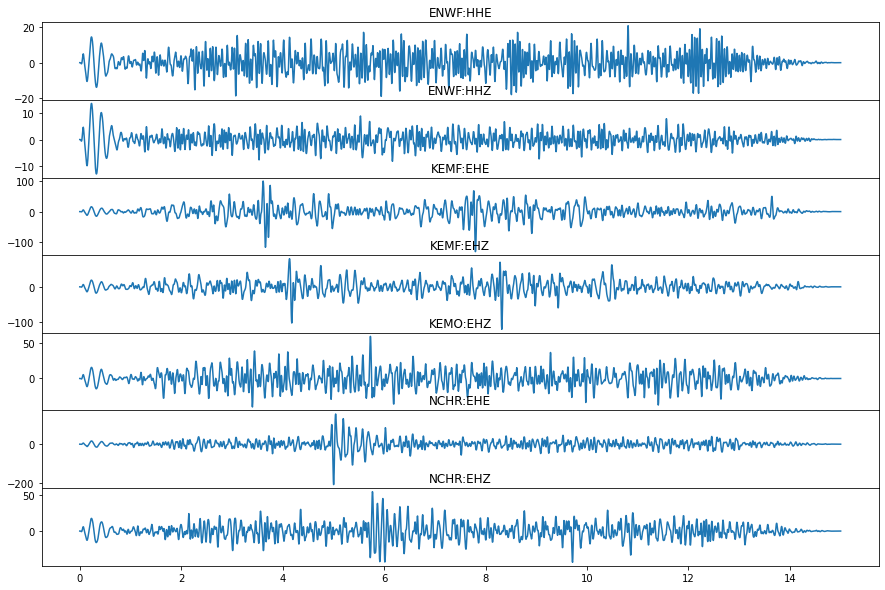

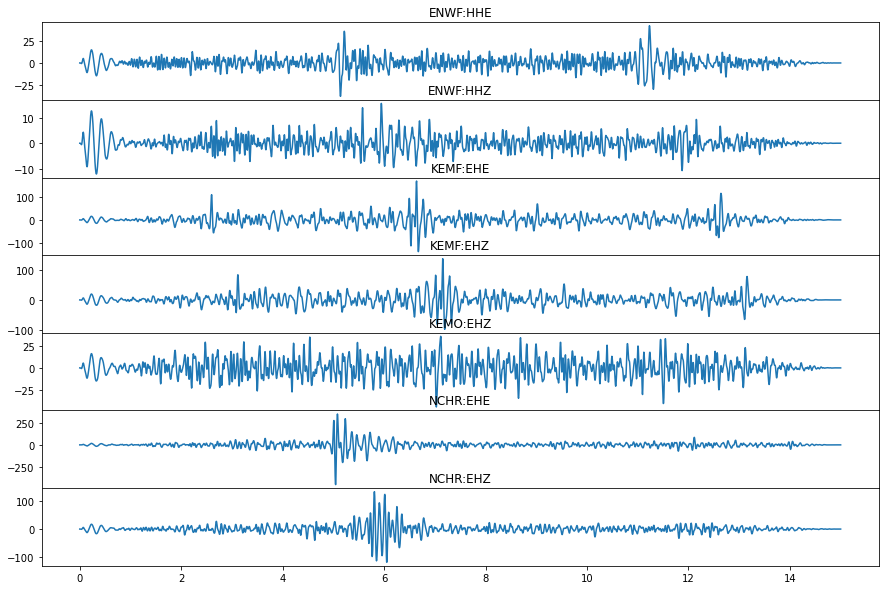

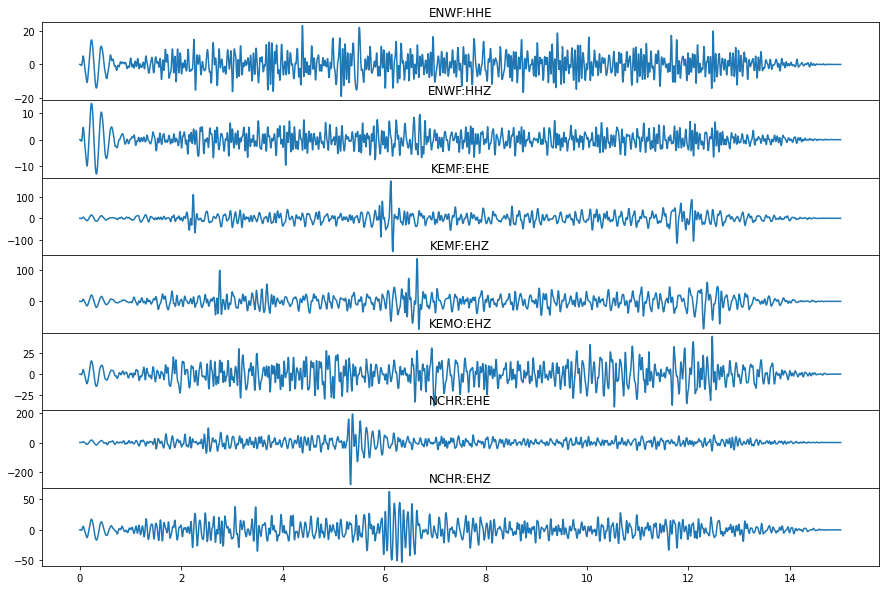

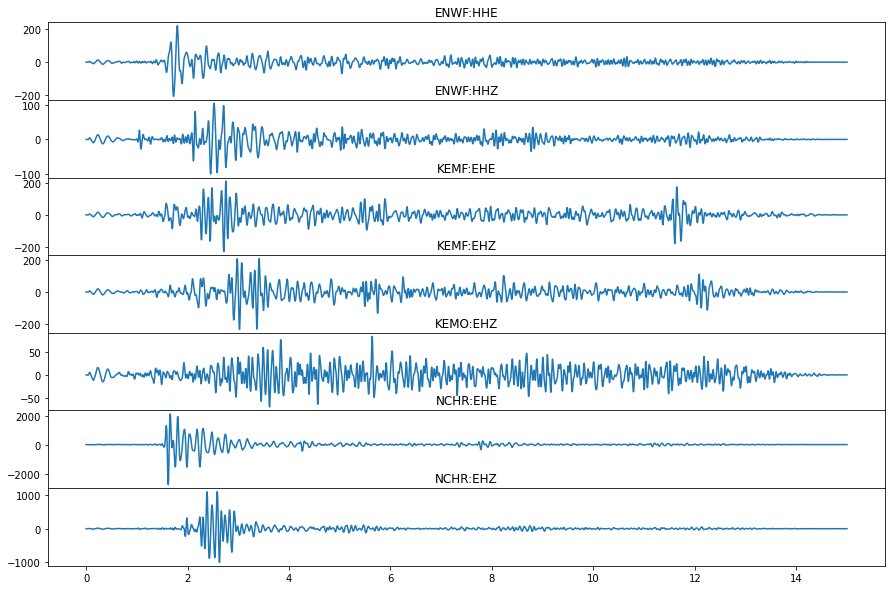

In [228]:
for ind in range(10):
    det = party[3][ind]
    fig = plt.figure(figsize=(15, 10))
    axs = fig.subplots(len(det.event.picks), 1, gridspec_kw={'hspace': 0})
    for i,pick in enumerate(det.event.picks):
        t1 = pick.time-5
        t2 = pick.time+10
        st = client.get_waveforms("NV",pick.waveform_id.station_code,pick.waveform_id.location_code,pick.waveform_id.channel_code,t1,t2)
        st.filter('bandpass',freqmin=5,freqmax=20)
        st = st.taper(max_percentage=0.2)
    
        axs[i].plot(st[0].times(),st[0].data) 
        axs[i].set_title(pick.waveform_id.station_code+':'+pick.waveform_id.channel_code)